# 利用Keras构建自动编码器
我们在这份学习指南中将回答有关`自动编码器`的一些常见问题，除此之外，我们也会给出下述模型的代码示例：
* 基于全连接层的简单自动编码器
* 稀疏自动编码器
* 深度全连接自动编码器
* 深度卷积自动编码器
* 图像降噪模型
* 序列到序列的自动编码器
* 变分自动编码器 

**注意：所有的代码示例已经在2017年3月14日更新到了Keras 2.0接口。你需要在Keras 2.0.0以及更高的版本下运行他们，本文所采用的环境为Keras 2.3.1。**   

## 什么是自动编码器？
![简单全连接自动编码器示例图](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

\begin{equation*}
\textrm{原始输入}  \longrightarrow \textrm{编码} \longrightarrow \textrm{压缩表示} \longrightarrow \textrm{解码} \longrightarrow \textrm{重构后的输入}
\end{equation*}
`自动编码器`是一种数据压缩算法，其中，压缩和解压函数具有以下三条特性：
* 1. 数据相关的。   
* 2. 有损的。
* 3. 自动地从样本中进行学习而不是通过人工特征工程进行特征提取。   

此外，我们不难发现，几乎在所有自动编码器这个词出现过的文章中，压缩和解压功能的实现都是通过神经网络来完成的。
* 1. 自动编码器是数据相关的，这意味着我们只可以压缩成和训练数据类似的数据。自编码器与一些压缩算法，如MPEG-2，MP3等压缩算法不同，这些算法只假设了数据是“图像”或“声音”，而没有指定是哪种图像或声音。如果我们使用自动编码器对人脸图像进行压缩，那么若用此模型对大树的图片进行压缩其表现会很差，因为自动编码器所学习到的特征是人脸所独有的。
* 2. 自动编码器是有损的，这意味着模型的解压输出没有其原始输入那么清晰，这一点区别于无损压缩算法，而与MP3或者JPEG等压缩算法相类似。
* 3. 自动编码器具有一个非常有用的特性，其可以自动地从数据样本中学习：这意味着很容易对指定类的输入训练出一种特定的编码器，而不需要其它新的工作。

为了搭建一个自动编码器，你需要以下三大工具：编码器，解码器，损失函数（用以衡量由于压缩而损失掉的信息）。编码器和解码器是关于损失函数可微的参数化方程，通常情况下用神经网络表示。由于其可微，我们可以使用随机梯度下降法优化编码器以及解码器以最小化损失函数。这个过程是非常简单的，你甚至不需要理解这些步骤也可以在实际中使用自动编码器。

## 自动编码器是一个好的数据压缩算法吗？
通常情况下，这个问题的答案是否定的。例如在图片压缩过程中，很难训练出一个自动编码器和JPEG等基础图片压缩算法相媲美。如果你想达到JPEG的压缩水平，就必须要把图片的类型限定在一个很小的范围内（例如JPEG压缩效果不好的某类图片）。自动编码器的数据相关性导致它们并不适用于现实生活中的数据压缩问题，你只可以将自动编码器应用在与训练数据相类似的数据集上，若你想提高模型的普适性，那么你需要准备大量的训练数据。但谁又知道未来算法的改进能否对这些情况做出改善呢。

## 自动编码器擅长做什么？
自动编码器很少应用于实际生活中。2012年人们发现在卷积神经网络中使用自编码器做逐层预训练可以训练深层网络[1]，但这个方法很快遭到了淘汰，因为人们发现随机权重初始化方案相比于自动编码器对于训练深层网络有效的多。在2014年，`批量标准化(batch normalization)`[2]开始应用在深度学习中。到2015年底，我们可以使用`残差学习(residual learning)`训练任意深度的神经网络[3]。    
目前，自动编码器在`数据降噪`（后文中将会提到）以及`数据降维可视化`方面取得有趣的实际应用。配合适当的维度和稀疏约束，自编码器可以学习到比PCA等技术更有意思的从高维空间到低维空间的数据投影。    
对于2维数据可视化，[t-SNE](https://www.jianshu.com/p/8c20b975a174)(发音读作 "tee-snee") 可能是目前最好的算法，但它通常需要相对低维的原始数据。所以利用自动编码器首先将原始数据压缩到低维空间（例如32维），然后用t-SNE流形学习降维算法将压缩后的数据投影到二维平面以观察其在高维空间中的相似性不失为一个好的方法。**注意：在Keras中已收录由Kyle McDonald开发的[参数化t-SNE实现](https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb)，另外[scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)也有一个简单实用的实现。**

## 所以自动编码器最大的用处是什么呢？
自编码器的出名来自于网上很多机器学习课程的介绍。最终，很多刚步入这个领域的新手对自动编码器爱不释手，这也是本篇学习指南存在的原因！    
除此之外，自动编码器能够吸引了足够多研究和关注的其中一个原因是因为该算法一直被认为是解决无监督学习的潜在解决方案，例如不需要标签便可以学习到数据有用的表示方法。其次，自动编码器不是一个真正的无监督学习算法，这意味着其与无监督学习算法有着不同的学习过程。自动编码器是`自监督学习算法`（无监督学习算法中标签源于输入数据的一种实例）。为了让自监督学习模型学习到有用的特征，你需要设定学习目标以及损失函数，而这也是问题的根源，仅仅把目标设定为重构输入可能不是正确的选项。有充足的证据证明机器学习模型能学习到高级的抽象特征(类比于人类“发明”的抽象概念例如“狗”，“猫”等等)，但是不能在像素级上精确重构输入。事实上，当你的主要任务是分类、定位之类的任务时，对这类任务而言的最好的特征基本上都是重构输入时的最差的那些特征。    
在应用自监督学习的视觉问题中，可能应用自动编码器的领域有例如拼图，细节纹理匹配（从低分辨率的图像块中匹配其高分辨率的对应块）。下面这篇文章研究了拼图问题，其实很有意思，不妨一读。 [Noroozi and Favaro (2016) Unsupervised Learning of Visual Representations by Solving Jigsaw Puzzles](https://arxiv.org/abs/1603.09246)。此类问题的模型输入有些内置的假设，例如“视觉块比像素级的细节更重要”等，这种假设是普通的自编码器没有的。
![拼图示例](https://blog.keras.io/img/ae/jigsaw-puzzle.png)

## 让我们构建最简单的自动编码器
我们先给出一个简单示例，该自动编码器只有一个全连接层充当编码器以及解码器的角色：

In [87]:
from keras.layers import Input, Dense
from keras.models import Model

# 这是我们编码器的大小
encoding_dim = 32  # 压缩为32个浮点数 -> 当输入为784个浮点数时，压缩率为24.5（784/32=24.5）

# 这是我们的输入层，神经元个数等于输入图像的维度
input_img_1 = Input(shape=(784,))
# "encoded" 是输入数据的编码表示
encoded_1 = Dense(encoding_dim, activation='relu')(input_img_1)
# "decoded" 是输入的有损重构
decoded_1 = Dense(784, activation='sigmoid')(encoded_1)

# 这个模型将一个输入映射到它的重构中
autoencoder_1 = Model(input_img_1, decoded_1)

我们也单独创建一个编码器：

In [2]:
# 这个模型将一个输入映射到它的编码表示中
encoder_1 = Model(input_img_1, encoded_1)

同样我们也单独创建一个解码器：

In [3]:
# 将已编码的结果输入到解码器中
decoded_input_1 = Input(shape=(encoding_dim,))
# 获取自编码器的最后一层
decoder_layer_1 = autoencoder_1.layers[-1]
# 创建解码器
decoder_1 = Model(decoded_input_1, decoder_layer_1(decoded_input_1))

现在我们在MNIST数据集上训练我们的模型，将手写数字图片进行重构。    
首先我们设定模型的损失函数为`binary crossentropy loss`，优化器为`Adadelta `

In [4]:
autoencoder_1.compile(optimizer='adadelta', loss='binary_crossentropy')

让我们准备我们的输入数据。我们在MNIST数据集上训练模型，并把数据集的标签全部丢掉（因为我们仅仅对输入图像的编码以及解码过程感兴趣）。

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

我们将图片矩阵数值归一化到0-1之间，并且把28\*28的图片矩阵拉伸为一个长度为784的向量。

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()                      # mnist手写数字数据集导入
x_train = x_train.astype('float32') / 255.                                    # 归一化
x_test = x_test.astype('float32') / 255.                                      # 归一化
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))         # 图片28*28转为1*784
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))             # 图片28*28转为1*784
print(x_train.shape)  
print(x_test.shape)

(60000, 784)
(10000, 784)


* `numpy.prod()`函数是**连乘**操作，将里面所有的元素相乘，示例如下：  
```python
In[1]:  import numpy as np
          a = np.array([1,2,3,4])
          print(np.prod(a))   
Out[1]: 24
```

现在开始训练我们的自动编码器并训练50轮：

In [7]:
autoencoder_1.summary()                                                          # 打印模型的结构
autoencoder_1.fit(x_train, x_train, epochs=100, batch_size=256,                  # 自编码器是要输出和输入尽可能的相似所以feature和label相同
                shuffle=True, validation_data=(x_test, x_test)) 

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 62us/step - loss: 0.3548 - val_loss: 0.2714
Epoch 2/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.2649 - val_loss: 0.2550
Epoch 3/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.2452 - val_loss: 0.2328
Epoch 4/100
60000

60000/60000 [==============================] - 4s 61us/step - loss: 0.1000 - val_loss: 0.0984
Epoch 71/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0999 - val_loss: 0.0983
Epoch 72/100
60000/60000 [==============================] - 2s 41us/step - loss: 0.0998 - val_loss: 0.0982
Epoch 73/100
60000/60000 [==============================] - 3s 45us/step - loss: 0.0997 - val_loss: 0.0981
Epoch 74/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.0996 - val_loss: 0.0980
Epoch 75/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0996 - val_loss: 0.0979
Epoch 76/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.0995 - val_loss: 0.0979
Epoch 77/100
60000/60000 [==============================] - 2s 39us/step - loss: 0.0994 - val_loss: 0.0978
Epoch 78/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.0993 - val_loss: 0.0977
Epoch 79/100
60000/60000 [========================

在训练100轮之后，自动编码器的损失值收敛于**0.0963**。我们尝试对重构输入以及编码表示进行可视化分析。我们将用到`Matplotlib`这个包。

In [8]:
# 对部分手写体数据进行编码和解码
# 我们从测试集中提取数据进行推理
encoded_imgs_1 = encoder_1.predict(x_test)
decoded_imgs_1 = decoder_1.predict(encoded_imgs_1)
encoded_imgs_1.mean()

8.669103

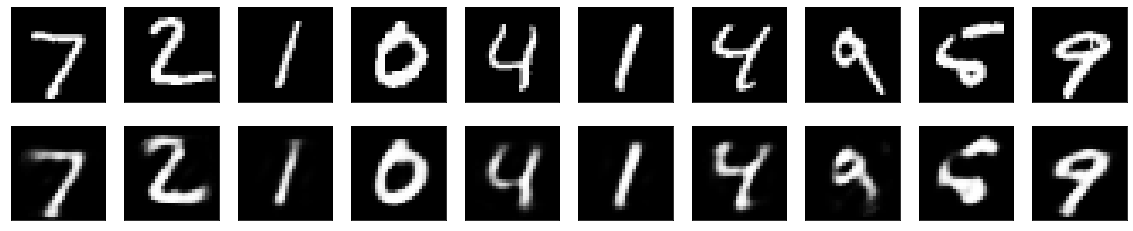

In [10]:
# 调用 Matplotlib 
import matplotlib.pyplot as plt

n = 10                                # 展示的图片数目
plt.figure(figsize=(20, 4))           # 图框大小设定
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)     # 子图位置设定
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()                        # 只有黑白两色,没有中间的渐进色
    ax.get_xaxis().set_visible(False) # 关闭坐标轴
    ax.get_yaxis().set_visible(False)
    
    # 重构图片可视化
    ax = plt.subplot(2, n, i + 1 + n) # 第2行
    plt.imshow(decoded_imgs_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

以上便是我们得到的结果，第一行为原始数据，第二行为重构后的数据。不难看出，使用这种基本方法，我们会丢失一些图片细节。

* **Keras模型的方法及属性**
```python
# 包含模型网络层的展平列表
In[1]:  autoencoder.layers 
Out[1]: [<keras.engine.input_layer.InputLayer at 0x15adab3d128>,
         <keras.layers.core.Dense at 0x15adab3d160>,
         <keras.layers.core.Dense at 0x15af0029b70>]
# 模型输入张量的列表
In[2]:  autoencoder.inputs
Out[2]: [<tf.Tensor 'input_1:0' shape=(None, 784) dtype=float32>]
# 模型输出张量的列表
In[3]:  autoencoder.outputs
Out[3]: [<tf.Tensor 'dense_2/Sigmoid:0' shape=(None, 784) dtype=float32>]
```

## 为编码表示添加稀疏约束
在上一个示例中，我们用一个拥有32个神经元的隐藏层构建了特征表示层。在这种情况下隐层能够学到的知识表示和[PCA主成分分析法](https://blog.csdn.net/program_developer/article/details/80632779)相差无几。但是如果我们对隐层单元施加稀疏性约束的话，这样只有一小部分神经元会被激活，从而得到更为紧凑的表示。在Keras中, 我们通过在`Dense`层添加`activity_regularizer`来实现此功能。

In [47]:
from keras import regularizers

encoding_dim = 32

input_img_2 = Input(shape=(784,))
# 给全连接层增加 L1 规则化项
encoded_2 = Dense(encoding_dim, activation='relu',
                kernel_regularizer=regularizers.l1(10e-5))(input_img_2)
decoded_2 = Dense(784, activation='sigmoid')(encoded_2)

autoencoder_2 = Model(input_img_2, decoded_2)

在设计深度学习模型的时候，我们经常需要使用正则化（`Regularization`）技巧来减少模型的过拟合效果，例如 `L1 正则化`、`L2 正则化`等。在Keras中，我们可以方便地使用三种正则化技巧：    
* `keras.regularizers.l1`
* `keras.regularizers.l2`
* `keras.regularizers.l1_l2`    
那么，我们应该如何使用这三种正则化技巧呢？以Keras中的`Dense`层为例，我们发现有以下三个参数：
* `kernel_regularizer`:对该层中的权值进行正则化，亦即对权值进行限制，使其不至于过大。大多数情况下，使用`kernel_regularizer`就足够了。
* `bias_regularizer`:与权值类似，限制该层中 biases 的大小。如果你希望输入和输出是接近的，你可以使用`bias_regularizer`。
* `activity_regularizer`:对该层的输出进行正则化。如果你希望该层的输出尽量小，你应该使用`activity_regularizer`。

让我们对这个模型进行100轮训练（在添加正则项之后会降低模型过拟合的可能性，同时也会导致训练时间变长）。

In [48]:
# 这个模型将一个输入映射到它的编码表示中
encoder_2 = Model(input_img_2, encoded_2)
# 将已编码的结果输入到解码器中
decoded_input_2 = Input(shape=(encoding_dim,))
# 获取自编码器的最后一层
decoder_layer_2 = autoencoder_2.layers[-1]
# 创建解码器
decoder_2 = Model(decoded_input_2, decoder_layer_2(decoded_input_2))
autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_2.summary()                                                          # 打印模型的结构
autoencoder_2.fit(x_train, x_train, epochs=100, batch_size=256,                  # 自编码器是要输出和输入尽可能的相似所以feature和label相同
                shuffle=True, validation_data=(x_test, x_test)) 

Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 53us/step - loss: 0.4452 - val_loss: 0.3408
Epoch 2/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.3194 - val_loss: 0.2986
Epoch 3/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.2845 - val_loss: 0.2704
Epoch 4/100
6000

60000/60000 [==============================] - 3s 47us/step - loss: 0.1534 - val_loss: 0.1516
Epoch 71/100
60000/60000 [==============================] - 3s 50us/step - loss: 0.1531 - val_loss: 0.1513
Epoch 72/100
60000/60000 [==============================] - 3s 46us/step - loss: 0.1529 - val_loss: 0.1511
Epoch 73/100
60000/60000 [==============================] - 3s 47us/step - loss: 0.1527 - val_loss: 0.1509
Epoch 74/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1524 - val_loss: 0.1506
Epoch 75/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1522 - val_loss: 0.1504
Epoch 76/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1520 - val_loss: 0.1502
Epoch 77/100
60000/60000 [==============================] - 3s 48us/step - loss: 0.1518 - val_loss: 0.1500
Epoch 78/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1516 - val_loss: 0.1498
Epoch 79/100
60000/60000 [========================

最终模型在训练集上的损失值为**0.1481**，在测试集上的损失值为**0.1463**。他们之间的差异主要是由于在训练过程中加了正则项而在测试过程中没有添加正则项造成的（相差大约0.002）

In [49]:
encoded_imgs_2 = encoder_2.predict(x_test)
decoded_imgs_2 = decoder_2.predict(encoded_imgs_2)
encoded_imgs_2.mean()

2.1426053

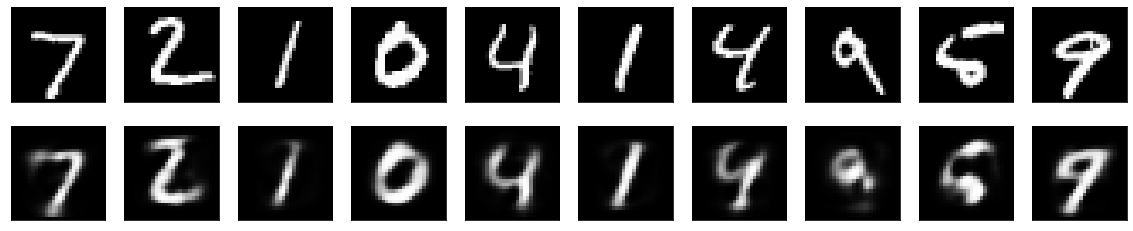

In [50]:
n = 10                                # 展示的图片数目
plt.figure(figsize=(20, 4))           # 图框大小设定
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)     # 子图位置设定
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()                        # 只有黑白两色,没有中间的渐进色
    ax.get_xaxis().set_visible(False) # 关闭坐标轴
    ax.get_yaxis().set_visible(False)
    
    # 重构图片可视化
    ax = plt.subplot(2, n, i + 1 + n) # 第2行
    plt.imshow(decoded_imgs_2[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

以上是我们得到的最新一组结果。这个看起来和我们的上一个模型差不多，唯一显著的区别是编码出来的码字更加稀疏了。`encoded_imgs.mean()`这个函数在我们10,000张测试集图片上计算得到的码字均值为`2.1426053`，然而之前模型的计算结果为`8.669103`，所以我们新模型生成的稀疏表示是原来模型稀疏性的4倍。

## 深度全连接自动编码器
只有一个隐层作为编码器或者解码器并不是一个强制性的约束，反而我们可以使用多层进行堆叠，例如这个样子：

In [51]:
input_img_3 = Input(shape=(784,))
encoded_3 = Dense(128, activation='relu')(input_img_3)
encoded_3 = Dense(64, activation='relu')(encoded_3)
encoded_3 = Dense(32, activation='relu')(encoded_3)

decoded_3 = Dense(64, activation='relu')(encoded_3)
decoded_3 = Dense(128, activation='relu')(decoded_3)
decoded_3 = Dense(784, activation='sigmoid')(decoded_3)

接下来让我们进行如下的尝试：

In [56]:
autoencoder_3 = Model(input_img_3, decoded_3)
autoencoder_3.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_3.summary()                                                          # 打印模型的结构
autoencoder_3.fit(x_train, x_train, epochs=100, batch_size=256, shuffle=True, validation_data=(x_test, x_test))
decoded_imgs_3 = autoencoder_3.predict(x_test)

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_26 (Dense)             (None, 784)               101

60000/60000 [==============================] - 4s 65us/step - loss: 0.1072 - val_loss: 0.1087
Epoch 66/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1070 - val_loss: 0.1068
Epoch 67/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1067 - val_loss: 0.1046
Epoch 68/100
60000/60000 [==============================] - 4s 63us/step - loss: 0.1065 - val_loss: 0.1041
Epoch 69/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1060 - val_loss: 0.1058
Epoch 70/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1058 - val_loss: 0.1044
Epoch 71/100
60000/60000 [==============================] - 4s 65us/step - loss: 0.1055 - val_loss: 0.1039
Epoch 72/100
60000/60000 [==============================] - 4s 64us/step - loss: 0.1052 - val_loss: 0.1039
Epoch 73/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.1050 - val_loss: 0.1035
Epoch 74/100
60000/60000 [========================

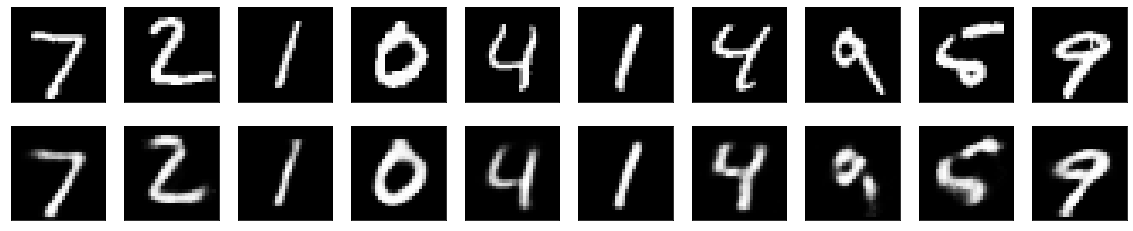

In [58]:
n = 10                                # 展示的图片数目
plt.figure(figsize=(20, 4))           # 图框大小设定
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)     # 子图位置设定
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()                        # 只有黑白两色,没有中间的渐进色
    ax.get_xaxis().set_visible(False) # 关闭坐标轴
    ax.get_yaxis().set_visible(False)
    
    # 重构图片可视化
    ax = plt.subplot(2, n, i + 1 + n) # 第2行
    plt.imshow(decoded_imgs_3[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

训练100轮之后，训练集和测试集上的损失值均在0.099左右，这个模型比我们之前的模型表现略微好一些，我们的手写体图像重构看起来也更好一些。

## 卷积自动编码器
由于我们的输入为图像，所以使用卷积神经网络作为编码器和解码器是有意义的。在实际应用中，卷积自动编码器由于在各方面表现更佳，所以更多地应用在图像领域中。     
接下来让我们来实现一个卷积自动编码器。编码器由`Conv2D`和`MaxPooling2D`层（MaxPooling负责空域下采样）的堆叠组成，解码器由` Conv2D`和`UpSampling2D `层的堆叠组成。

In [59]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # 当图像配置为 `channels_first` 时使用此输入

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 到这一步为止，128维将以(4, 4, 8)进行表示

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

为了对此模型进行训练，我们将使用原始的MNIST数据集，该数据集的大小为 **(samples, 3, 28, 28)**，并且我们仅仅将图片的像素值归一化到0到1。

In [60]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # 若模型配置为`channels_first`则对数据做此维度变换
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))     # 若模型配置为`channels_first`则对数据做此维度变换

让我们对此模型训练50轮。为了可视化训练过程的损失情况，我们使用TensorFlow作为后端，这样就可以启用`TensorBoard`了。   
打开一个终端切换到代码目录下并用如下命令启动TensorBoard，TensorBoard将读取位于logs的日志文件：

\begin{remark}\label{rem:1}
tensorboard --logdir=F:\博士\相关文献\code\mnist\logs
\end{remark}

接下来让我们开始训练模型，在回调列表中我们传入TensorBoard回调的实例，当每训练完一轮时，这个回调函数将会在logs文件夹下写日志。这些日志都是可以被TensorBoard所读取的。

In [66]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='logs')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 120s 2ms/step - loss: 0.2100 - val_loss: 0.1646
Epoch 2/50
60000/60000 [==============================] - 106s 2ms/step - loss: 0.1501 - val_loss: 0.1429
Epoch 3/50
60000/60000 [==============================] - 101s 2ms/step - loss: 0.1353 - val_loss: 0.1327
Epoch 4/50
60000/60000 [==============================] - 102s 2ms/step - loss: 0.1279 - val_loss: 0.1244
Epoch 5/50
60000/60000 [==============================] - 99s 2ms/step - loss: 0.1229 - val_loss: 0.1208
Epoch 6/50
60000/60000 [==============================] - 97s 2ms/step - loss: 0.1201 - val_loss: 0.1156
Epoch 7/50
60000/60000 [==============================] - 96s 2ms/step - loss: 0.1178 - val_loss: 0.1138
Epoch 8/50
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1162 - val_loss: 0.1150
Epoch 9/50
60000/60000 [==============================] - 95s 2ms/step - loss: 0.1141 - val_loss: 0.1101
E

In [72]:
autoencoder.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0  

通过在浏览器中输入http://localhost:6006/ ，我们便可以在TensorBoard的网页界面监视训练过程。
![训练过程](https://blog.keras.io/img/ae/tb_curves.png)

模型的损失值收敛于`0.0970`，比我们之前模型的表现都要好一些（**这主要归功于128维的编码器相比于之前的32维编码器，大大提高了系统的复杂程度**）。让我们观察一下重构后的手写体数字。

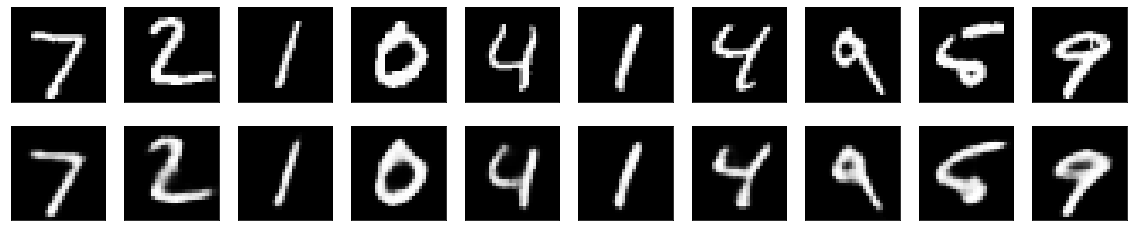

In [68]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重构图片可视化
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

我们可以看到128维的编码器运行结果如下图所示。由于编码器模型最终输出图片的维度为8\*4\*4，所以我们先把他们转换为4\*32，以显示这些图片的灰度图。

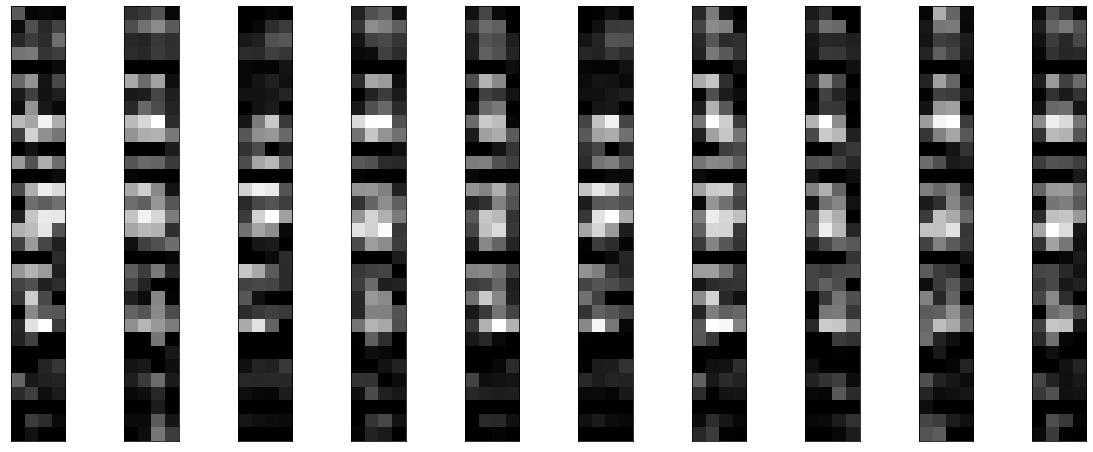

In [71]:
# 从网络中提取编码器部分，注意从中间层进行抽取之前，整个模型必须通过编译
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 在图片噪中的应用
接下来，我们利用卷积自动编码器解决一个图片降噪问题。这个过程是很简单的：我们将训练自动编码器，使其能够在有噪声的图片和无噪声的图片之间进行映射。      
我们来演示如何合成有噪声的手写数字图片：我们在图片上添加高斯白噪声，并将图片像素`clip`到0到1之间。

* **numpy.clip**使用方法为：`numpy.clip(a, a_min, a_max, out=None)[source]` 其中a是一个数组，后面两个参数分别表示最小和最大值。
```python
In[1]:  import numpy as np
          x = np.array([1,2,3,5,6,7,8,9])
          np.clip(x,3,8)  
Out[1]: array([3, 3, 3, 5, 6, 7, 8, 8])
```
`clip`这个函数将将数组中的元素限制在a_min, a_max之间，大于a_max的就使得它等于 a_max，小于a_min,的就使得它等于a_min，高维数组也是一样的。

* **np.random.normal()**生成正态分布序列。    
高斯分布的概率密度函数
\begin{equation}\label{eq:}
f(x)=\frac{1}{\sqrt{2\pi}\sigma}e^\frac{(x-\mu)^2}{2\sigma^2}
\end{equation}
* `numpy.random.normal(loc=0.0, scale=1.0, size=None) `参数的意义：
* 1. `loc:float`:概率分布的均值，对应着整个分布的中心
* 2. `scale:float`:概率分布的标准差，对应于分布的宽度，scale越大越矮胖，scale越小，越瘦高
* 3. `size:int or tuple of ints`:输出的shape，默认为None，只输出一个值
```python
In[1]:  import numpy as np
             np.random.normal(loc=0.0, scale=1.0, size=12)  
Out[1]: array([ 1.7774364 ,  1.11441167,  0.04059996,  0.53853637, -0.87072645,
                     0.86840441,  0.04738635,  1.35138895, -0.06652018,  0.96001949,
                     -0.14320103,  0.52479529])
```

In [75]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) # 矩阵相加
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

手写体数字图片加噪后如下图所示：

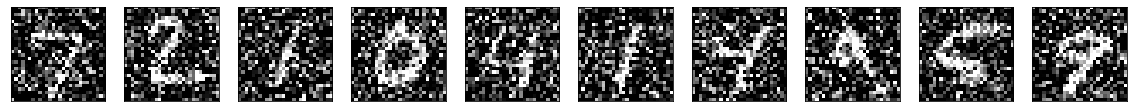

In [76]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

如果你眯眼看可能还能勉强认出这些数字，那我们的自动编码器能学会恢复这些图到原图吗？让我们拭目以待。    
和之前的卷积自动编码器相比，为了提高重构图像的质量，我们将对模型做出略微的调整，使其每一层拥有更多的卷积核数目。

In [77]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 到这一步为止，图像的维度将以(7, 7, 32)进行表示 

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

* `UpSampling2D`可以看作是`Pooling`的反向操作，就是采用Nearest Neighbor interpolation来进行放大，说白了就是复制行和列的数据来扩充feature map的大小。

让我们对这个模型训练10轮

In [79]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='logs_nois', histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 177s 3ms/step - loss: 0.0999 - val_loss: 0.0991
Epoch 2/10
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0995 - val_loss: 0.0981
Epoch 3/10
60000/60000 [==============================] - 173s 3ms/step - loss: 0.0993 - val_loss: 0.0975
Epoch 4/10
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0991 - val_loss: 0.0979
Epoch 5/10
60000/60000 [==============================] - 169s 3ms/step - loss: 0.0987 - val_loss: 0.0982
Epoch 6/10
60000/60000 [==============================] - 185s 3ms/step - loss: 0.0984 - val_loss: 0.0978
Epoch 7/10
60000/60000 [==============================] - 190s 3ms/step - loss: 0.0983 - val_loss: 0.0981
Epoch 8/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0982 - val_loss: 0.0971
Epoch 9/10
60000/60000 [==============================] - 176s 3ms/step - loss: 0.0979 - val_loss: 0.0

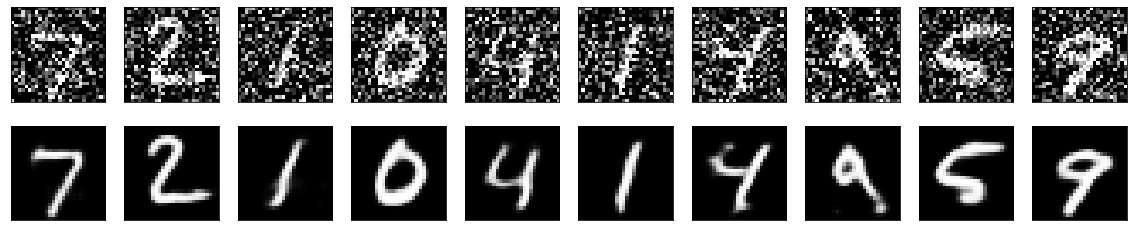

In [80]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重构图片可视化
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

现在让我们观察一下得到的结果吧。第一行为喂给神经网络的有噪声图片，第二行为神经网络重构后的输出结果。    
看起来我们的神经网络表现很好。如果你想训练大规模卷积神经网络，你可以尝试构建文档降噪或者音频降噪模型。[Kaggle可以为你提供一个有趣的数据集来训练模型](https://www.kaggle.com/c/denoising-dirty-documents)。

## 序列到序列自动编码器
如果你的输入是序列，而不是向量或者二维图片，那么你可能想要使用LSTM构成的编码器和解码器来捕捉输入序列的时间结构。为了构建一个基于LSTM的自动编码器，首先使用一个LSTM编码器将你的输入序列转换为一个包含全部序列信息的向量，然后将这个向量重复`n`次（`n`是输出序列的时间间隔数量），最后运行一个LSTM解码器将这个n步的时间序列转换为目标序列。     
我们不会在特定的数据集上展示序列到序列自动编码器。我们仅仅给出部分示例代码为以后的读者作为参考！

In [84]:
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

timesteps = 1   # 仅仅作为假设
input_dim = 1   # 仅仅作为假设
latent_dim = 1  # 仅仅作为假设

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

## 变分自动编码器 
变分自编码器是一种更先进、更有趣的自编码方式。    
你可能会问什么是变分自动编码器。它对模型学到的编码表示添加约束，更确切地说，它可以学习到输入数据的[潜变量模型](https://blog.csdn.net/ziliwangmoe/article/details/87292443)。这样的话，神经网络学习到的不再是一个任意函数，而是学习数据概率分布的一组参数。通过在这个概率分布中采样，你可以生成新的输入数据，即变分编码器是一个生成模型。      
* 变分自动编码器是如何工作的？     

首先，编码网络将输入样本`x`转换为隐空间的两个参数，我们将其分别记为`z_mean`和`z_log_sigma`。然后，我们随机从隐藏的正态分布中采集相似点`z`，这个隐藏分布我们假设就是产生输入数据的那个分布。通过式(2)
\begin{equation}\label{eq:2}
z = z\_mean + exp(z\_log\_sigma) * epsilon
\end{equation}
其中，epsilon是一个服从正态分布的张量。    
最后，使用解码器网络将隐空间映射到显空间，即将`z`转换回原来的输入数据空间。     
这个模型的参数通过两个损失函数进行训练：重构损失函数促使解码后的数据和初始输入数据尽可能一样（就像我们之前提到过的自动编码器一样），第二项损失函数是学习到的隐分布与先验分布的[KL距离](https://blog.csdn.net/gao1440156051/article/details/44162269)，作为一个正则。实际上把后面这项损失函数去掉也可以，尽管它对学习符合要求的隐空间和防止过拟合有帮助。    
由于变分自动编码器是一个更加复杂的示例，我们将其代码示例作为一个单独的脚本在[Github](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)上开源，我们接下来将逐步复现这个模型。     
首先构造我们的编码模型，将输入映射为隐分布的参数：
```python
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)
```
编码部分的网络结构图如下图所示：
![encoder](img\vae_mlp_encoder.png)
我们可以利用这些参数从隐空间采样新的相似点：
```python
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

# 注意："output_shape"这个参数在使用TensorFlow做为后端时不是必要的
# 所以你也可以这样使用函数 `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
```
最终，将采样得到的点映射回去重构原输入：
```
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
```
解码部分的网络结构图如下图所示：
![decoder](img\vae_mlp_decoder.png)    
我们目前所做的工作可以帮助我们实例化以下三个模型：    
* 用于将输入与重构图片相映射的端到端的自动编码器
* 一个将输入映射到隐空间的编码器
* 一个可以从隐空间采集样本点的生成器，其可以输出与输入一致的重构样本    

```python
# 端到端的自动编码器
vae = Model(x, x_decoded_mean)

# 编码器，从输入到隐空间
encoder = Model(x, z_mean)

# 生成器，从隐空间到重构的输入
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)
```      
我们利用端到端的模型训练网络，并使用自定义的损失函数，由重构误差项和KL距离项组成。
```python
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='rmsprop', loss=vae_loss)
```
我们在MNIST数据集上训练变分自动编码器：
```python
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))
```
因为我们的隐空间是二维的，所以其可视化方法比较有限。其中一种方法是在隐二维平面内观察不同类的临近值：
```python
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()
```
![scatter](img\vae_mean.png)  
图片中每一种颜色代表一簇手写体数组图像，不同簇之间距离越接近代表其手写体数字的结构越接近（手写体数字图像在隐空间共享信息）。    
由于变分自动编码器是一个生成模型，所以我们可以利用它生成新的手写体数字图片！我们将扫描隐空间，等间隔地从隐空间中进行采样，并对这些样本点生成结构一致的手写体数字图片。这给了我们一种对于“生成”的MNIST数字的可视化方案。
```python
# 对于手写体数字可视化其二维流形
n = 15  # 图片的大小为15*15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# 我们在[-15, 15]均匀采集n个点
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
```
![隐空间可视化](img\digits_over_latent.png)     

###  利用变分自动编码器生成手写体数字图像
变分自动编码器在MNIST数据集上的应用（利用多层感知器实现）。变分自动编码器是模块化结构，其包括三大部分编码器、解码器以及变分自动编码器，这三部分共享权重。变分自动编码器经过训练之后，编码器可以被用作产生隐向量，解码器可以被用作生成MNIST数据集（通过在标准正态分布中采样隐向量）。这部分的参考文献为[4] Kingma, Diederik P., and Max Welling. "[Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)." 

In [88]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [98]:
# 导入数据
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]   # x_train.shape = (60000, 28, 28)
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


* `numpy.reshape`在不改变数据的情况下改变数组的维度，使用方法如下：numpy.reshape(a, newshape, order='C')    
参数：
* `a` : 是一个数组
            代表要被转换的数组   
* `newshape` : int型或int型组成的元组     
            新的维度应该和数组原来的维度相兼容。如果新的维度是用一个整数表示，那么将返回该整数长度的一维数组。当然维度也可以用-1代替，               如果这样的话，系统根据原来数组的长度推理出新的维度。    
* `order ` : {‘C’, ‘F’, ‘A’}, 可选参数
```python
>>> a = np.arange(6).reshape((3, 2))
>>> a
array([[0, 1],
       [2, 3],
       [4, 5]])
>>> np.reshape(a, (2, 3)) # C-like index ordering
array([[0, 1, 2],
       [3, 4, 5]])
>>> np.reshape(np.ravel(a), (2, 3)) # equivalent to C ravel then C reshape
array([[0, 1, 2],
       [3, 4, 5]])
>>> np.reshape(a, (2, 3), order='F') # Fortran-like index ordering
array([[0, 4, 3],
       [2, 1, 5]])
>>> np.reshape(np.ravel(a, order='F'), (2, 3), order='F')
array([[0, 4, 3],
       [2, 1, 5]])
```

In [99]:
# 重参数化技巧
# 不是通过Q(z|X)进行采样, 样本分布服从N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """
    通过从独立同分布的高斯分布中进行采样从而实现重参数化
    参数：
        args (张量): Q(z|X)的方差的均值以及对数
    返回：
        z (张量): 采样后的隐向量
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # 默认情况下，random_normal 是 mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [100]:
# 构建网络
## 网络参数
input_shape = (original_dim, )    # 输入层神经元个数
intermediate_dim = 512            # 中间层神经元个数
batch_size = 128
latent_dim = 2                    # 隐空间神经元个数
epochs = 50
## 变分自动编码器 = 编码器 + 解码器

## 构建编码器模型
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
## 使用重参数化技巧将采样输出作为输入
## 注意："output_shape" 对于TensorFlow作为后端不是必要参数
## keras.layers.core.Lambda(function, output_shape=None, mask=None, arguments=None)
## Lambda函数接受两个参数，第一个是输入张量对输出张量的映射函数，第二个是输入的shape对输出的shape的映射函数。function：要实现的函数，该函数仅接受一个变量，即上一层的输出
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
## 实例化编码模型
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)  # 保存编码模型结构图

# 构建解码器模型
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
## 实例化解码模型
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)  # 保存解码模型结构图

## 实例化变分自动编码器模型
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_32[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_32[0][0]                   
____________________________________________________________________________________________

In [101]:
# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# plot_model(vae, to_file='vae_mlp.png', show_shapes=True)  # 绘制变分自动编码器模型
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

D:\Users\wuzhe\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 20s 337us/step - loss: 198.1813 - val_loss: 173.7917
Epoch 2/50
60000/60000 [==============================] - 20s 334us/step - loss: 169.6358 - val_loss: 167.0659
Epoch 3/50
60000/60000 [==============================] - 20s 339us/step - loss: 165.5093 - val_loss: 164.5754


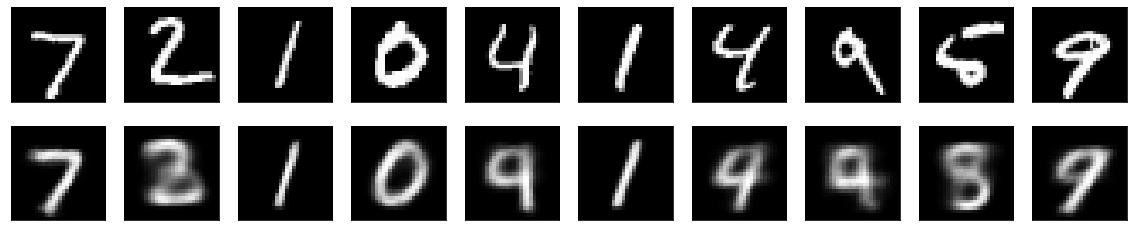

In [105]:
decoded_imgs = vae.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # 对原始数据进行可视化
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 重构图片可视化
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 参考文献
[1] [Why does unsupervised pre-training help deep learning?](http://www.jmlr.org/papers/volume11/erhan10a/erhan10a.pdf)     
[2] [Batch normalization: Accelerating deep network training by reducing internal covariate shift.](https://arxiv.org/abs/1502.03167)     
[3] [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)     
[4] [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)     
[5] [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)  
[6] [Building Autoencoders in Keras cn](https://keras-cn.readthedocs.io/en/latest/legacy/blog/autoencoder/)